# Problem Set 5, due June 1 at 11:59 pm.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [52]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews.fresh.dropna()
reviews = reviews[reviews.quote.str.len() > 0]

reviews.quote = reviews.quote.str.replace('[^\w\s]', '')
reviews.quote = reviews.quote.str.replace('[0-9]', '')

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [53]:
# enter your code below

print ("Number of reviews: %i" % len(reviews))
print("Number of unique quotes: ", len(reviews.quote.unique()))
print("Number of unique critics: ", len(reviews.critic.unique()))
print("Number of unique movies: ", len(movies.title.unique()))
print("Number of different publications have reviews: ", len(reviews.publication.unique()))


Number of reviews: 13419
Number of unique quotes:  12813
Number of unique critics:  541
Number of unique movies:  9405
Number of different publications have reviews:  64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

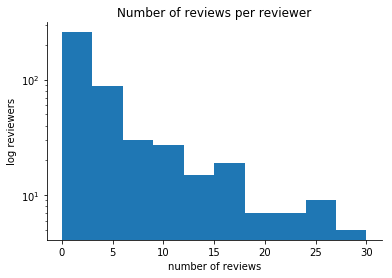

In [54]:
# enter your code here
# plots graph, changes color, changes bins to $1000
temp = reviews.groupby('critic').count()
temp = temp['quote']



plt.hist(temp, log = True, range = (0,30))
#axes = plt.gca()
#axes.set_ylim([0,1200])

ax = plt.axes()
plt.title('Number of reviews per reviewer')
plt.xlabel('number of reviews')
plt.ylabel('log reviewers')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [55]:
# enter your code here
temp = reviews.groupby('critic').count()
df = temp.nlargest(30, 'quote')
names = df.index
storage = {}
for name in names:
    df = reviews.loc[reviews['critic'] == name]
    pub = df.publication.unique()
    datef = df.review_date.min()
    datel = df.review_date.max()
    a_list = [pub, datef, datel]
    storage[name] = a_list
    
df = pd.DataFrame.from_dict(storage)
df

,Bosley Crowther,Dave Kehr,Derek Adams,Desson Thomson,Edward Guthmann,Emanuel Levy,Geoff Andrew,Hal Hinson,James Berardinelli,Janet Maslin,...,Richard Corliss,Richard Schickel,Rick Groen,Rita Kempley,Roger Ebert,Stephen Holden,Susan Stark,Todd McCarthy,Variety Staff,Vincent Canby
0,[New York Times],"[Chicago Reader, New York Daily News, Chicago ...",[Time Out],[Washington Post],[San Francisco Chronicle],[Variety],[Time Out],[Washington Post],[ReelViews],[New York Times],...,[TIME Magazine],"[TIME Magazine, The Atlantic]",[Globe and Mail],[Washington Post],"[Chicago Sun-Times, At the Movies]",[New York Times],[Detroit News],[Variety],[Variety],[New York Times]
1,2000-01-01 00:00:00,2000-01-01 00:00:00,2006-01-26 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2005-08-11 00:00:00,2000-01-01 00:00:00,1800-01-01 00:00:00,2000-01-01 00:00:00,...,2003-12-16 00:00:00,2000-01-01 00:00:00,2002-03-19 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2001-02-13 00:00:00,2000-01-01 00:00:00
2,2008-05-06 00:00:00,2013-11-20 00:00:00,2009-10-04 00:00:00,2012-10-08 00:00:00,2003-04-04 00:00:00,2010-08-06 00:00:00,2012-04-05 00:00:00,2013-06-26 00:00:00,2012-02-07 00:00:00,2010-09-07 00:00:00,...,2013-11-06 00:00:00,2013-08-05 00:00:00,2009-08-14 00:00:00,2013-11-02 00:00:00,2013-06-11 00:00:00,2009-02-06 00:00:00,2002-10-25 00:00:00,2012-10-09 00:00:00,2012-08-15 00:00:00,2013-07-29 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

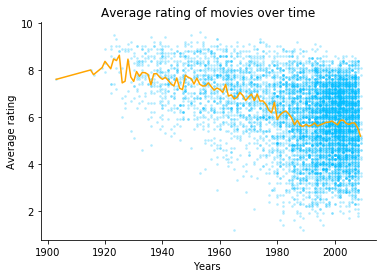

In [56]:
# enter your code here
# getting rid of unknows and 0 values
movies = movies[movies['rtAllCriticsRating'] != '\\N']
movies = movies[movies['rtAllCriticsRating'] != '0']


# changing movie data into float values
movies_float = movies.copy()
params = ['rtAllCriticsRating', 'rtAllCriticsNumReviews', 'rtAllCriticsNumFresh',
'rtAllCriticsNumRotten','rtAllCriticsScore','rtTopCriticsRating','rtTopCriticsNumReviews',
'rtTopCriticsNumFresh','rtTopCriticsNumRotten','rtTopCriticsScore','rtAudienceRating',
'rtAudienceNumRatings','rtAudienceScore']
def makeFloats(df, params):
    for param in params:
        df[param] = pd.to_numeric(df['rtAllCriticsRating'], errors='coerce')

# changing movies values into floats 
makeFloats(movies_float, params)  

by_year = movies_float.groupby('year')['rtAllCriticsRating'].mean()

# scatter plots
ax = plt.axes()
ax.scatter(movies.year, movies.rtAllCriticsRating.apply(float), s = 3, alpha = .2, color = 'deepskyblue')

# for drawing the line 
ax.plot(by_year, color = 'orange')

plt.title('Average rating of movies over time')
plt.xlabel('Years ')
plt.ylabel('Average rating')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)







There are a lot more reviews in the last 30 years. The average review is also slightly lower. Perhaps more movies have been produced, and movie expectations have increased. 

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [57]:
# X, Y = make_xy(reviews)
# print(X.shape, Y.shape)
import io
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)

# cleaning quotes before extracting features

result = []
lines = np.array(reviews.quote)
print(lines.shape)
for row in lines:
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in row.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n '.join(chunk for chunk in chunks if chunk)
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace("\n", ' ').replace('\\b', ' ')
    # gets rid of escape characters
    text = bytes(text, "utf-8").decode("unicode_escape")
    # gets rid of links 
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    # getting rid of punctuation 
    text = ''.join(ch for ch in text if ch not in exclude)
    # make text lower case
    text = text.lower()

    # remove stop words before csv was written
    text = word_tokenize(text)
    resultwords  = [word for word in text if word not in stop_words]
    text = ' '.join(resultwords)
    result.append(text)

# adding clean words to reviews df
clean = np.array(result)
clean.size
reviews['clean'] = clean

# getting rid of null, empty rows in "clean" column
reviews = reviews[~reviews.clean.isnull()]
reviews = reviews[reviews.clean.str.len() > 0]
reviews = reviews.dropna()

(13419,)


In [58]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print ("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print ("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [76]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)

"""
from string import digits
import string

# removing punction and numbers from quotes


# so runs on my computer
#n_reviews = reviews[0:1000]
vec = CountVectorizer(min_df=0)
def make_xy(reviews, vec=None):
    if vec == None:
        vec = CountVectorizer(min_df=0, stop_words='english')
    X = vec.fit(reviews.clean)
    X = vec.transform(reviews.clean)
    X = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
    X = X.fillna(0)
    X = np.array(X)
    Y = reviews.fresh.replace('fresh',1).replace('rotten',0) 
    Y = np.array(Y)
    return X, Y


In [60]:
X,Y = make_xy(reviews)


### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [77]:
# enter your code here
# splitting test and train data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12345, test_size=0.33)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [78]:
# call the fitted model fitted_model, for future reference:
fitted_model = MultinomialNB()
fitted_model.fit(X_train, y_train)
print("accuracy score of train data: ", fitted_model.score(X_train, y_train))
preds = fitted_model.predict(X_test)

# preds score (percentage of the time that the predictions equal the data)
accuracy = (preds == y_test).sum()/len(y_test)
print("accuracy of predictions: ", accuracy)

accuracy score of train data:  0.938622227438
accuracy of predictions:  0.766738146295


Though the training data had a great score, the model only predicted correctly about 60% of the time. Perhaps too many features? 

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [32]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [79]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood_score(y, y_pred, estimator):
    prob = estimator.predict_log_proba(y)
    rotten = y_pred == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood_score(X_test, y_test, fitted_model)

-2443.7688806015612

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

#for alpha in alphas:
score = make_scorer(log_likelihood_score)
# param_grid for gridsearchCV
param_grid ={'alpha': alphas }

for min_df in min_dfs:
    for alpha in alphas: 
        # creating new CountVectorizer with assigned min_dif
        vectorizer = CountVectorizer(min_df = min_df)  
        X, Y = make_xy(reviews, vectorizer)
        # splitting train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12345, test_size=0.33)
        # using grid search for cross validation. 
        #grid = GridSearchCV(MultinomialNB(), param_grid = param_grid, n_jobs=6)
        score = cross_val_score(MultinomialNB(alpha = alpha), X_train, y_train, cv=KFold(n_splits = 10, shuffle=True), scoring = log_likelihood_score).mean()
        #grid.fit(X_train, y_train)
        #best_score = grid.best_score_ 
        #llh = log_likelihood_score(grid, X_train, y_train)
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df
            


/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by 

In [83]:
print("Max_loglike:", max_loglike, "best alpha: ", best_alpha, "best min_df:", best_min_df )


Max_loglike:  -453.942512987 best alpha:  5 best min_df: 0.001


from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# using grid search
# creating parameters for pipeline for cross validation: 
pipeline = Pipeline([
     ('vect', CountVectorizer()),
      ('model', MultinomialNB()),
 ])

# parameters to tweek in pipeline
param_grid ={'vect__min_df': min_dfs,
             'model__alpha': [0, .1, 1, 5, 10, 50]}


score = make_scorer(log_likelihood_score, needs_proba = True, greater_is_better = True, estimator = pipeline)

# re-splitting data without converting into CountVector to put into pipeline
X_train, X_test, y_train, y_test = train_test_split(reviews.quote, reviews.fresh.replace('fresh', 1).replace('rotten', 0), random_state = 12345, test_size=0.33)

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block
    
    #finding best alpha and min_df

    grid = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1, scoring = score)
    grid.fit(X_train, y_train)
    log_like = log_likelihood_score(grid, X_train, y_train)
    print(log_like)
    print('accuracy: ', grid.score(X_train, y_train))
    print("pipeline:", [name for name, _ in pipeline.steps])
    best_parameters = grid.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\tbest parameters for ", param_name)
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [85]:
vec = CountVectorizer(min_df=best_min_df)
X, Y = make_xy(reviews, vec)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12345, test_size=0.33)

fitted_model = MultinomialNB(alpha=best_alpha)
fitted_model.fit(X_train, y_train)
print("accuracy score of train data: ", fitted_model.score(X_train, y_train))
preds = fitted_model.predict(X_test)

# preds score (percentage of the time that the predictions equal the data)
accuracy = (preds == y_test).sum()/len(y_test)
print("accuracy of predictions: ", accuracy)

accuracy score of train data:  0.797206900599
accuracy of predictions:  0.735763640696


In [135]:
#Enter your code here
print(X_test.shape)
X_train.shape
fitted_model.classes_

(4197, 22268)


array([0, 1])

This new model had slightly better predictions, but the same train data accuracy. May perhaps slightly better with handeling overfitting

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [103]:
#Enter your code here

*enter your observations here*

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [86]:
# geting feature names
words = vec.get_feature_names()

# finding predicted propability using trained model and words
i = np.identity(len(words))
df = pd.DataFrame(i, columns = words)
prop = fitted_model.predict_proba(df)  


In [87]:
# puting predicted propabilites of each word in a dataframe for easier wrangeling 
props = pd.DataFrame(prop, columns = ['prop_rot', 'prop_fresh'])
props['word'] = words
print("Top 10 words that best predict fresh reviews\n",props.nlargest(10, 'prop_fresh'))
print()
print("Top 10 words that best predict rotten reviews\n",props.nlargest(10, 'prop_rot'))


Top 10 words that best predict fresh reviews
       prop_rot  prop_fresh         word
902   0.102726    0.897274  intelligent
1809  0.102726    0.897274     touching
419   0.128710    0.871290      delight
1074  0.132433    0.867567  masterpiece
1701  0.132433    0.867567       superb
1382  0.144000    0.856000         rare
154   0.146383    0.853617         best
316   0.146561    0.853439      complex
750   0.146561    0.853439        gives
139   0.147346    0.852654    beautiful

Top 10 words that best predict rotten reviews
       prop_rot  prop_fresh             word
1861  0.810396    0.189604    unfortunately
968   0.808175    0.191825             lame
1306  0.785571    0.214429        pointless
608   0.770551    0.229449            fails
1862  0.767290    0.232710          unfunny
168   0.758465    0.241535            bland
1863  0.756929    0.243071       uninspired
1339  0.753267    0.246733          problem
457   0.753267    0.246733   disappointment
456   0.745602    0.254398

This is a really fun exercise, and good sanity check on my model! All of these words make sence to be in either a fresh or rotten review. I also included the predicted propability for a further sanity check.  

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [233]:
#Your code here

# looks at all the words and eaching qote, and then gives a general rating based on the classified propability 
# of that word being in a fresh or rotten review
new_lines = np.array(reviews.clean)
ratings = []
for line in new_lines: 
    r = 0
    f = 0
    for w in line.split():

        value = props.loc[props.word == w]
        if not value.word.empty:
            v1 = value['prop_rot']
            v2 = value['prop_fresh']
            if(v1.item() > v2.item()):
                r +=1
            else:
                f += 1
    if(r > f):
        rate = 0
    else:
        rate = 1
        
    ratings.append(rate)


In [256]:
# appends preds to reviews df
reviews['pred'] = ratings
reviews.fresh = reviews.fresh.replace('fresh', 1).replace('rotten', 0)

# looking where preds and fresh ratings do not match 
df = reviews[reviews.pred != reviews.fresh]

# printing incorrect ratings 
quotes = np.array(df.quote)
print("INCORRECTLY CLASSIFIED RATINGS")
print()
for i in range(0,5):
    print(i, ")", quotes[i])
    print()

INCORRECTLY CLASSIFIED RATINGS

0 ) A gloomy specialeffects extravaganza filled with grotesque images generating fear and despair

1 ) The movie is too pat and practiced to really be convincing and the progress of Ariels relationships with the two grumps seems dictated mostly by the needs of the screenplay

2 ) Never escapes the queasy aura of Melrose Place just another story about beautiful people with small problems

3 ) The malebashing taken to an extreme in Waiting to Exhale is starting to seem a little like crack for the female psyche exhilarating in the short term but ultimately crippling and dangerous

4 ) With one possible exception none of its women is at all likable



These miss  predictions contain words that are highly rated fresh but in a rotten review or highly rated rotten by in a fresh review. This is because Niave Bayes calassifiers look at each word independtly and removes context. Context is a huge part of the english language; a way to compat this may be to bag multiple words, rather than singular words. The example review above would get fresh rating from the classifier because it contains a large number of fresh words. However, this would be wrong.  

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [88]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,outcome
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


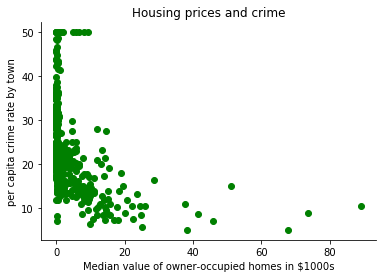

In [197]:
# Enter your code here
%matplotlib inline  
import matplotlib.pyplot as plt  

# puting data in dataframe
data_pd = pd.DataFrame(columns=bdata.feature_names, data=bdata.data)
data_pd['outcome'] = bdata.target 

# plots graph, changes color, changes bins to $1000
plt.scatter(data_pd.CRIM,bdata.target, color='green')

# Adds appropriate labels to the x and y axes 
plt.title('Housing prices and crime')
plt.xlabel('Median value of owner-occupied homes in $1000s')
plt.ylabel('per capita crime rate by town')

#Remove the axes on the top and right side of the plot window
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
data_pd

In [96]:
# for computing rmse
def compute_rmse(predictions, yvalues):
   
    total_sum = 0
    for i, value in enumerate(yvalues):
        dif = (predictions[i] - yvalues[i]) ** 2
        total_sum = total_sum + dif
    f = total_sum / len(yvalues)
    rmse = np.sqrt(f)
    return rmse


In [153]:
# splitting train/test data
features = data_pd.RM
print(features.shape)
target = data_pd.outcome
print(target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 12345, test_size=0.34)

#reshaping for linear regresssion
X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(506,)
(506,)
(333, 1) (333, 1)
(173, 1) (173, 1)


In [158]:
from sklearn.linear_model import LinearRegression

# regression model
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
pred = regr.predict(X_test)

# checking RMSE
rmse = compute_rmse(pred,y_test)
print('RMSE:', rmse[0])

RMSE: 6.41925719387


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

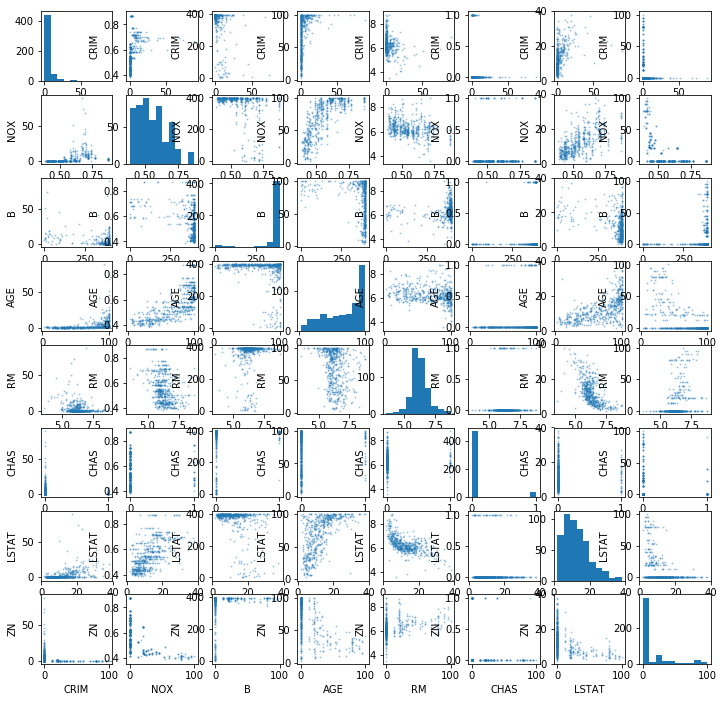

In [205]:
plt.figure(figsize=(12,12))
f = ['CRIM', 'NOX', 'B', 'AGE', 'RM', 'CHAS', 'LSTAT', 'ZN']
for i in range(8):
    for j in range(8):
       
        fig = plt.subplot(8, 8, i * 8 + j + 1)
        if i != j:
            plt.scatter(data_pd[f[i]],data_pd[f[j]], alpha = .3, s = 1, label = f[i])
            plt.ylabel(f[i])
            plt.xlabel(f[j])
        else :
            plt.hist(data_pd[f[i]])
        
        # insert your code here

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [214]:
# seperating features and outcome
x = data_pd.drop('outcome', axis =1) 
y = data_pd.outcome

#splitting data
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 12345, test_size=0.34)
scaler = StandardScaler()

# standardizing training data
data_scaled = scaler.fit_transform(X_train)

# implementing PCA
pca = PCA(n_components = 12)
new_data = pca.fit_transform(X_train)

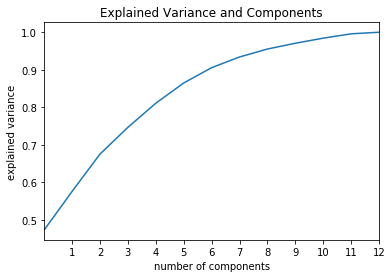

In [203]:
# ploting explained variance and pca compenents 
plt.xlim(0,12)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
pca=PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance and Components")
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

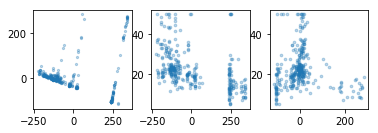

In [244]:
# Enter your code here
pca2 = PCA(n_components = 2)
f2 = pca2.fit_transform(X_train)
plt.subplot(231)
plt.scatter(f2[:,0], f2[:,1], s = 5, alpha = .3)
plt.subplot(232)
plt.scatter(f2[:,0], y_train, s = 7, alpha = .3)
plt.subplot(233)
plt.scatter(f2[:,1], y_train, s = 7, alpha = .3)

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

*Enter your observations here*